In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 12

from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm

import seaborn as sns

from imblearn.over_sampling import SMOTE

Matplotlib is building the font cache; this may take a moment.


In [48]:
df = pd.read_csv("/Users/ianchang/0.Workspaces/slaCoefficientProject/Origination Data/DTT SLA Summary - Overall Summary.csv").drop(columns=["Unnamed: 0", "partner_id", "partner", "xfr_request_id", "request_id", "true_SLA", "runtime_per_day", "payment_code"])

In [49]:
df['submit_date'] = pd.to_datetime(df['submit_date'])
df["submit_date"] = df["submit_date"].dt.floor('D')

# Extract year and month, then create the submit_month column
df['submit_month'] = df['submit_date'].dt.to_period('M')

In [53]:
origination_by_month = df[["on_time", "submit_month"]].groupby(by="submit_month").mean()
origination_by_month

,submit_month,on_time
0,2022-01,0.996694
1,2022-02,0.997963
2,2022-03,0.998839
3,2022-04,0.993880
4,2022-05,0.992995
5,2022-06,0.996360
6,2022-07,0.995117
7,2022-08,0.994681
8,2022-09,0.980000
9,2022-10,0.994949


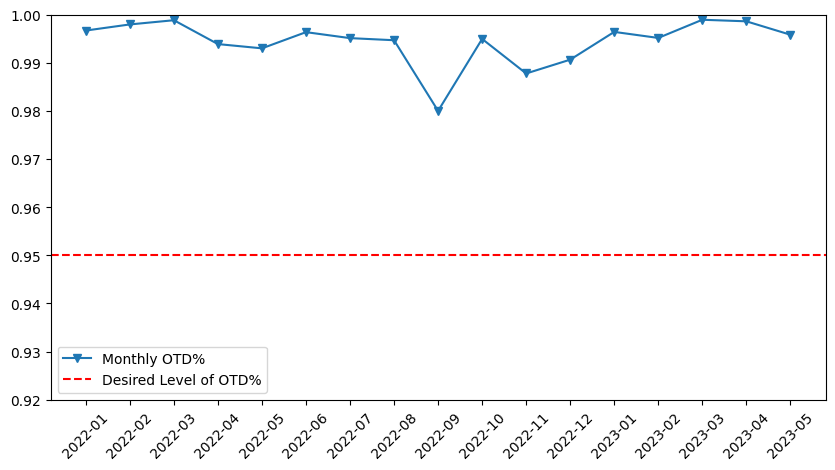

In [68]:
fig, ax = plt.subplots(figsize = (10,5))

ax.plot(origination_by_month["submit_month"].astype("str"), origination_by_month["on_time"], marker="v", label="Monthly OTD%")


ax.set_ylim(0.92, 1)
ax.axhline(y=0.95, color='red', linestyle='--', label="Desired Level of OTD%")

plt.xticks(rotation=45)
plt.legend()
plt.show()